# Constructing, running, and post-processing a MODFLOW groundwater model

FloPy is a popular Python package for constructing, running, and post-processing MODFLOW models.  In this example, we will demonstrate how FloPy can be used to create a numerical model of groundwater extraction.

We will work through the following steps as part of this notebook:
* Step 1. Copy and paste the getting started example from the [FloPy Website](https://github.com/modflowpy/flopy/tree/develop?tab=readme-ov-file#getting-started)
* Step 2. Modify the example to simulate steady-state groundwater extraction from a single well in the center of the domain
* Step 3. Modify the example for transient conditions
* Step 4. Modify the example to include multiple groundwater extraction wells

In [25]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import flopy

## Step 1. Run Flopy Getting Started example

Copy the MODFLOW 6 quickstart example from the [FloPy Website](https://github.com/modflowpy/flopy/tree/develop?tab=readme-ov-file#getting-started) and make sure that it runs.  Note that you will need MODFLOW in your path in order for the example to run properly.

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mymodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 2 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../../.local/share/flopy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:29:14 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the soft

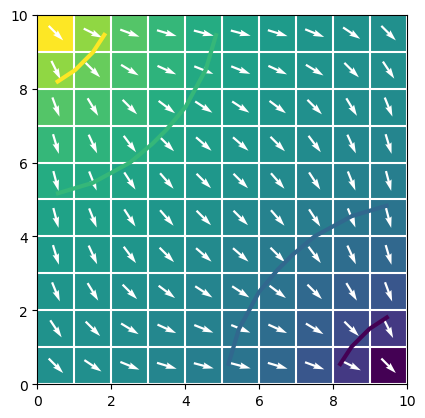

In [26]:
# copy quickstart example and make sure it works
import flopy
ws = './mymodel'
name = 'mymodel'
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(gwf, nrow=10, ncol=10)
ic = flopy.mf6.ModflowGwfic(gwf, strt=1)
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True, k=10.)
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, 0), 1.],
                                                       [(0, 9, 9), 0.]])
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
sim.write_simulation()
sim.run_simulation()

head = gwf.output.head().get_data()
bud = gwf.output.budget()

spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
pmv = flopy.plot.PlotMapView(gwf)
pmv.plot_array(head)
pmv.plot_grid(colors='white')
pmv.contour_array(head, levels=[.2, .4, .6, .8], linewidths=3.)
pmv.plot_vector(qx, qy, normalize=True, color="white")

## Step 2. Modify example for steady-state groundwater extraction

There are several things we will need to do in order to modify the FloPy quickstart example to represent our groundwater extraction problem.  These include:

1.  Modify the Discretization (DIS) Package to properly set nlay, nrow, ncol, delr, delc, top, and botm.
2.  Modify the Node Property Flow (NPF) Package to properly set the hydraulic conductivity (named `k`).
3.  Modify the Constant Head (CHD) Package to assign constant heads around the perimeter of the model with a value of 10.
4.  Modify the Well (WEL) Package to assign an extraction well in the middle of the model domain.

Let's set the following variables to help us modify this example

```
# dis
length_x = 150000
length_y = 150000
nrow = 21
ncol = 21
delr = length_x / ncol
delc = length_y / nrow
nlay = 1
top = 10.
botm = 0.

# npf
hydraulic_conductivity = 100.

# chd
ibound = np.empty((nlay, nrow, ncol), dtype=int)
ibound.fill(-1)
ibound[:, 1:nrow-1, 1:ncol-1] = 1
layers, rows, columns = np.where(ibound == -1)
chd_spd = [[l, r, c, 10.] for l, r, c in zip(layers, rows, columns)]

# wel
well_row = int((nrow - 1) / 2)
well_column = int((ncol - 1) / 2)
well_q = -1000.
wel_spd = [[0, well_row, well_column, well_q]]
```

In [27]:
# ibound = np.empty((nlay, nrow, ncol), dtype=int)
# ibound.fill(-1)
# ibound[:, 1:nrow-1, 1:ncol-1] = 1
# ibound
# layers, rows, columns = np.where(ibound == -1)
# layers, rows, columns
# chd_spd = [[l, r, c, 10.] for l, r, c in zip(layers, rows, columns)]
# chd_spd

In [28]:
# set the dis, npf, chd, and wel variables
# dis
length_x = 150000
length_y = 150000
nrow = 101
ncol = 101
delr = length_x / ncol
delc = length_y / nrow
nlay = 1
top = 10.
botm = 0.

# npf
hydraulic_conductivity = 100.

# chd
ibound = np.empty((nlay, nrow, ncol), dtype=int)
ibound.fill(-1)
ibound[:, 1:nrow-1, 1:ncol-1] = 1
layers, rows, columns = np.where(ibound == -1)
chd_spd = [[l, r, c, 10.] for l, r, c in zip(layers, rows, columns)]

# wel
well_row = int((nrow - 1) / 2)
well_column = int((ncol - 1) / 2)
well_q = -1000.
wel_spd = [[0, well_row, well_column, well_q]]
wel_spd

[[0, 50, 50, -1000.0]]

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mymodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 400 based on size of stress_period_data
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../../.local/share/flopy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:29:14 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                 

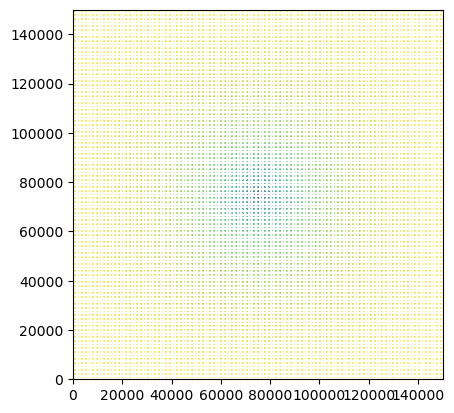

In [29]:
# copy the quickstart example and update the dis, npf, chd, and wel variables
import flopy
ws = './mymodel'
name = 'mymodel'
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(
    gwf, 
    nrow=nrow, 
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)
ic = flopy.mf6.ModflowGwfic(gwf, strt=1)
npf = flopy.mf6.ModflowGwfnpf(
    gwf, 
    save_specific_discharge=True, 
    k=hydraulic_conductivity,
)
chd = flopy.mf6.ModflowGwfchd(
    gwf, 
    stress_period_data=chd_spd
)
wel = flopy.mf6.ModflowGwfwel(
    gwf, 
    stress_period_data=wel_spd
)
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
sim.write_simulation()
sim.run_simulation()

head = gwf.output.head().get_data()
bud = gwf.output.budget()

spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
pmv = flopy.plot.PlotMapView(gwf)
pmv.plot_array(head)
pmv.plot_grid(colors='white')
pmv.contour_array(head, levels=[.2, .4, .6, .8], linewidths=3.)
pmv.plot_vector(qx, qy, normalize=True, color="white")

## Step 3. Modify the example for transient conditions

To change the steady state model from Step 2 into a transient model, we need to:
1.  Change information in the Temporal Discretization (TDIS) Package
2.  Assign a proper starting head to the Initial Conditions (IC) Package

```
# TDIS Package
nper = 1
nstp = 100
perlen = 100.
tsmult = 1.
perioddata = [(perlen, nstp, tsmult)]

# IC Package
strt = 10.
```

In [30]:
# set the tdis and ic variables
# TDIS Package
nper = 1
nstp = 100 # number of time steps
perlen = 100. # days
tsmult = 1.
perioddata = [(perlen, nstp, tsmult)]

# IC Package
strt = 10.

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mymodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 400 based on size of stress_period_data
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../../.local/share/flopy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:29:14 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version

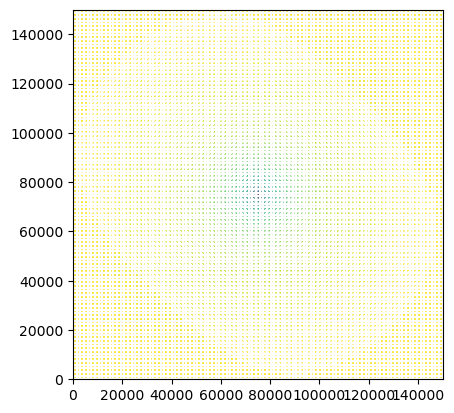

In [31]:
# copy the script from step 2 and update the tdis and ic variables
import flopy
ws = './mymodel'
name = 'mymodel'
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim, perioddata=perioddata)
ims = flopy.mf6.ModflowIms(sim)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(
    gwf, 
    nrow=nrow, 
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)
npf = flopy.mf6.ModflowGwfnpf(
    gwf, 
    save_specific_discharge=True, 
    k=hydraulic_conductivity,
)
sto = flopy.mf6.ModflowGwfsto(gwf, ss=1.e-5)
chd = flopy.mf6.ModflowGwfchd(
    gwf, 
    stress_period_data=chd_spd
)
wel = flopy.mf6.ModflowGwfwel(
    gwf, 
    stress_period_data=wel_spd
)
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
sim.write_simulation()
sim.run_simulation()

head = gwf.output.head().get_data()
bud = gwf.output.budget()

spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
pmv = flopy.plot.PlotMapView(gwf)
pmv.plot_array(head)
pmv.plot_grid(colors='white')
pmv.contour_array(head, levels=[.2, .4, .6, .8], linewidths=3.)
pmv.plot_vector(qx, qy, normalize=True, color="white")

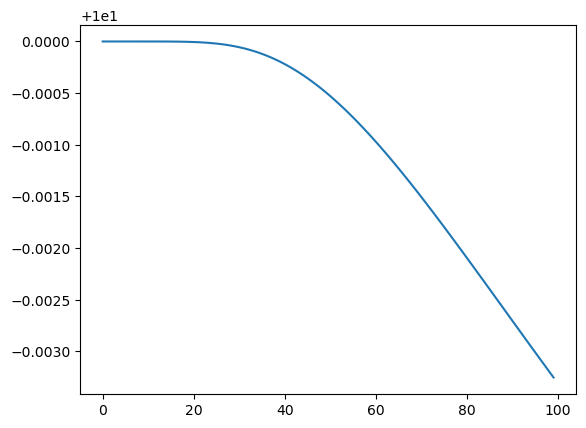

In [32]:
# make a plot of drawdown versus time for the model cell with the well
head = gwf.output.head().get_alldata()
plt.plot(head[:, 0, 10, 10])

## Step 4. Transient simulation with multiple pumping wells

Using the following `well_list`, create a well stress period variable.

In [33]:
well_text = """WELL1 49988.2 40903.66 605.0
WELL2 42195.49 5996.99 12.0
WELL3 14583.68 15884.9 716.0
WELL4 34448.56 27964.24 334.0
WELL5 22419.85 31224.71 100.0
WELL6 32417.15 4822.61 439.0
WELL7 16320.24 13385.98 694.0
WELL8 45323.84 36436.13 651.0
WELL9 28248.69 39668.15 558.0
WELL10 11045.92 31436.03 418.0
WELL11 10566.4 8672.29 730.0
WELL12 695.16 33597.84 268.0
WELL13 9036.03 2583.99 312.0
WELL14 44124.26 35123.48 483.0
WELL15 22434.9 35106.7 845.0
WELL16 22566.33 33533.98 506.0
WELL17 2285.95 1383.14 62.0
"""

# Create the list of wells (offset by 50000)
well_list = []
for w in well_text.splitlines():
    w = w.split()
    t = (w[0], float(w[1]) + 50000., float(w[2]) + 50000, float(w[3]))
    well_list.append(t)
well_list

[('WELL1', 99988.2, 90903.66, 605.0),
 ('WELL2', 92195.48999999999, 55996.99, 12.0),
 ('WELL3', 64583.68, 65884.9, 716.0),
 ('WELL4', 84448.56, 77964.24, 334.0),
 ('WELL5', 72419.85, 81224.70999999999, 100.0),
 ('WELL6', 82417.15, 54822.61, 439.0),
 ('WELL7', 66320.24, 63385.979999999996, 694.0),
 ('WELL8', 95323.84, 86436.13, 651.0),
 ('WELL9', 78248.69, 89668.15, 558.0),
 ('WELL10', 61045.92, 81436.03, 418.0),
 ('WELL11', 60566.4, 58672.29, 730.0),
 ('WELL12', 50695.16, 83597.84, 268.0),
 ('WELL13', 59036.03, 52583.99, 312.0),
 ('WELL14', 94124.26000000001, 85123.48000000001, 483.0),
 ('WELL15', 72434.9, 85106.7, 845.0),
 ('WELL16', 72566.33, 83533.98000000001, 506.0),
 ('WELL17', 52285.95, 51383.14, 62.0)]

In [34]:
# Create well stress period data by interesting each well with modelgrid
wel_spd = []
for w in well_list:
    wx = w[1]
    wy = w[2]
    w_i, w_j = gwf.modelgrid.intersect(wx, wy)
    wt = (0, w_i, w_j, -w[3])
    wel_spd.append(wt)
wel_spd

[(0, 39, 67, -605.0),
 (0, 63, 62, -12.0),
 (0, 56, 43, -716.0),
 (0, 48, 56, -334.0),
 (0, 46, 48, -100.0),
 (0, 64, 55, -439.0),
 (0, 58, 44, -694.0),
 (0, 42, 64, -651.0),
 (0, 40, 52, -558.0),
 (0, 46, 41, -418.0),
 (0, 61, 40, -730.0),
 (0, 44, 34, -268.0),
 (0, 65, 39, -312.0),
 (0, 43, 63, -483.0),
 (0, 43, 48, -845.0),
 (0, 44, 48, -506.0),
 (0, 66, 35, -62.0)]

In [35]:
# copy the script from step 3 and simulate extraction from multiple wells

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mymodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 400 based on size of stress_period_data
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 17 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../../.local/share/flopy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:29:14 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Versio

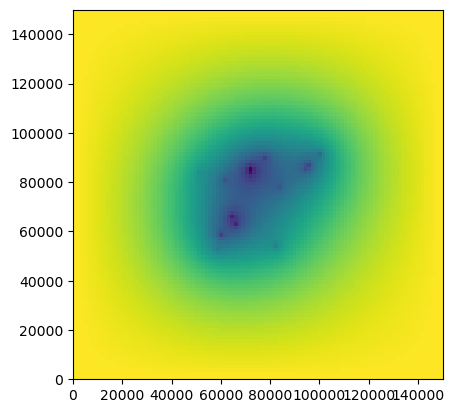

In [37]:
import flopy
ws = './mymodel'
name = 'mymodel'
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim, perioddata=perioddata)
ims = flopy.mf6.ModflowIms(sim)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(
    gwf, 
    nrow=nrow, 
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)
npf = flopy.mf6.ModflowGwfnpf(
    gwf, 
    save_specific_discharge=True, 
    k=hydraulic_conductivity,
)
sto = flopy.mf6.ModflowGwfsto(gwf, ss=1.e-5)
chd = flopy.mf6.ModflowGwfchd(
    gwf, 
    stress_period_data=chd_spd
)
wel = flopy.mf6.ModflowGwfwel(
    gwf, 
    stress_period_data=wel_spd
)
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
sim.write_simulation()
sim.run_simulation()

head = gwf.output.head().get_data()
bud = gwf.output.budget()

spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
pmv = flopy.plot.PlotMapView(gwf)
pmv.plot_array(head)
# pmv.plot_grid(colors='white')
pmv.contour_array(head, levels=[.2, .4, .6, .8], linewidths=3.)
# pmv.plot_vector(qx, qy, normalize=True, color="white")

In [43]:
gwf.get_package_list()

['DIS', 'IC', 'NPF', 'STO', 'CHD_0', 'WEL_0', 'OC']

In [49]:
ws = './mymodel'
name = 'mymodel'
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim, perioddata=perioddata)
ims = flopy.mf6.ModflowIms(sim)

gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(
    gwf, 
    nrow=nrow, 
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)
npf = flopy.mf6.ModflowGwfnpf(
    gwf, 
    save_specific_discharge=True, 
    k=hydraulic_conductivity,
)
sto = flopy.mf6.ModflowGwfsto(gwf, ss=1.e-5)
chd = flopy.mf6.ModflowGwfchd(
    gwf, 
    stress_period_data=chd_spd
)
wel = flopy.mf6.ModflowGwfwel(
    gwf, 
    stress_period_data=wel_spd
)
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])


In [47]:
pwd

'/Users/langevin/langevin/training/2024_WashingtonHydrogeologySymposium/whs2024/notebooks'

In [51]:
sim_ws = "mymodel"

sim = flopy.mf6.MFSimulation.load(sim_ws=sim_ws)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package chd...
    loading package wel...
    loading package oc...
  loading solution package mymodel...
